In [21]:
from scipy import spatial
import numpy as np
import math
import pandas as pd
import geopandas as gpd
import quadtree

In [22]:
df = pd.read_csv("starbucks_directory.csv")

gdf = gpd.GeoDataFrame(df, crs="EPSG:4326", geometry=
                    gpd.points_from_xy(x=df.Longitude, y=df.Latitude)).to_crs("EPSG:3395")

<AxesSubplot:>

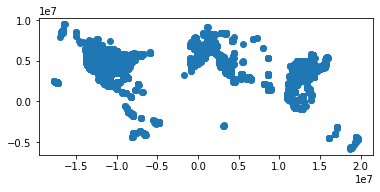

In [23]:
gdf.plot()

In [75]:
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:4326", "epsg:3395")
U_OF_I = transformer.transform(40.638, -88.1341)

search_radius = 5*10000*1.61 #1 mile

In [76]:
coords = np.array(list(zip(gdf.geometry.x,gdf.geometry.y)))

In [78]:
tree = spatial.KDTree(coords)
rslt_index_kd_tree = tree.query_ball_point(U_OF_I, search_radius)

In [79]:
rslt_index_kd_tree

[17345, 17346, 17347, 17348, 17344, 17369, 17390]

In [80]:
gdf.iloc[rslt_index_kd_tree,]

,Brand,Store Name,Street Address,City,State/Province,Country,Longitude,Latitude,geometry
17345,Starbucks,Champaign - 5th & Green,503 E. Green Street,Champaign,IL,US,-88.23,40.11,POINT (-9821718.673 4854406.278)
17346,Starbucks,University of Illinois-Illini Union,1401 W Green St,Urbana,IL,US,-88.23,40.11,POINT (-9821718.673 4854406.278)
17347,Starbucks,University of Illinois - Gregory St,701 S. GREGORY,URBANA,IL,US,-88.22,40.11,POINT (-9820605.478 4854406.278)
17348,Starbucks,Urbana-Main & Vine,102 N Vine Street,Urbana,IL,US,-88.20,40.11,POINT (-9818379.088 4854406.278)
17344,Starbucks,Unv of Illinois Champaign-Bookstore,809 S Wright St,Champaign,IL,US,-88.23,40.11,POINT (-9821718.673 4854406.278)
17369,Teavana,Teavana - Market Place Mall,"2000 N. Neil St., #375",Champaign,IL,US,-88.24,40.14,POINT (-9822831.868 4858756.660)
17390,Starbucks,Champaign - N Prospect Ave,2702 North Prospect,Champaign,IL,US,-88.26,40.15,POINT (-9825058.257 4860207.217)


In [82]:
def eu_dist(pt_1, pt_2):
    dist = math.sqrt(((pt_1[0]-pt_2[0])**2)+((pt_1[1]-pt_2[1])**2))
    return dist

def list_query(coords, pt, dist):
    rslt = []
    for i in range(len(coords)):
        if eu_dist(coords[i], pt) <= dist:
            rslt.append(i)
    return rslt

In [83]:
rslt_index_list = list_query(coords,U_OF_I, search_radius)

In [84]:
gdf.iloc[rslt_index_list,]

,Brand,Store Name,Street Address,City,State/Province,Country,Longitude,Latitude,geometry
17344,Starbucks,Unv of Illinois Champaign-Bookstore,809 S Wright St,Champaign,IL,US,-88.23,40.11,POINT (-9821718.673 4854406.278)
17345,Starbucks,Champaign - 5th & Green,503 E. Green Street,Champaign,IL,US,-88.23,40.11,POINT (-9821718.673 4854406.278)
17346,Starbucks,University of Illinois-Illini Union,1401 W Green St,Urbana,IL,US,-88.23,40.11,POINT (-9821718.673 4854406.278)
17347,Starbucks,University of Illinois - Gregory St,701 S. GREGORY,URBANA,IL,US,-88.22,40.11,POINT (-9820605.478 4854406.278)
17348,Starbucks,Urbana-Main & Vine,102 N Vine Street,Urbana,IL,US,-88.20,40.11,POINT (-9818379.088 4854406.278)
17369,Teavana,Teavana - Market Place Mall,"2000 N. Neil St., #375",Champaign,IL,US,-88.24,40.14,POINT (-9822831.868 4858756.660)
17390,Starbucks,Champaign - N Prospect Ave,2702 North Prospect,Champaign,IL,US,-88.26,40.15,POINT (-9825058.257 4860207.217)


In [89]:
from quadtree import Point, Rect, QuadTree

box = np.max(coords,axis=0) - np.min(coords,axis=0)
center = np.mean(coords,axis=0)

qtree = QuadTree(Rect(center[0], center[1], box[0], box[1]))

for i in range(len(coords)):
    point = Point(coords[i][0],coords[i][1],label=df["Store Name"][i])
    qtree.insert(point)

qtree.query_radius(U_OF_I, search_radius, [])

[(-9821718.672690528, 4854406.278179898): 'Unv of Illinois Champaign-Bookstore',
 (-9821718.672690528, 4854406.278179898): 'Champaign - 5th & Green',
 (-9821718.672690528, 4854406.278179898): 'University of Illinois-Illini Union',
 (-9820605.477782594, 4854406.278179898): 'University of Illinois - Gregory St',
 (-9818379.087966729, 4854406.278179898): 'Urbana-Main & Vine',
 (-9822831.86759846, 4858756.6599538345): 'Teavana - Market Place Mall',
 (-9825058.257414326, 4860207.217369193): 'Champaign - N Prospect Ave']

In [90]:
%timeit list_query(coords, U_OF_I, search_radius)

36 ms ± 274 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [91]:
%timeit qtree.query_radius(U_OF_I, search_radius, [])

128 µs ± 292 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [ ]:
%timeit tree.query_ball_point(U_OF_I. search_radius)